# **Final Project: Natural Language to Shell Command (NL2Sh)**
- This system will translate the user's natural language description of the task to shell command. With three agents: clarifier, composer, and inspector, the system will explain the user's task, compose a command, and inspect the command. If there is a mistake, a guide will be proposed by the inspector.
- This is the demo notebook of our project, which include the most steps from data preparation, agent pipeline initialization, inference, and E2E evaluation.
>P.S: Fine-tune steps will be finished on OpenAI Platform, so the code of this part is not included.

In [1]:
from datetime import datetime

start_timestamp = datetime.now()
print(f"Start time: {start_timestamp.strftime('%H:%M:%S')}")

Start time: 23:18:45


## Install Environment

In [2]:
# Create virtual environment and install all packages needed
!python -m venv .venv
!source .venv/bin.activate
!pip install .

/bin/bash: line 1: .venv/bin.activate: No such file or directory
Processing /home/cybercricetus/Desktop/myThingz/schoolThings/grad_1/dl/NL2Sh
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for NL2Sh: filename=nl2sh-0.1.0-py3-none-any.whl size=115344 sha256=be2f6fbbc50b0dc3bf285692f90018d0cadde89b09dd8c1607c9da32decb02d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-34w3zxkg/wheels/50/07/6c/925f157105bacd6271a21f211be14dde8dccf2dcf91dabf554
Successfully built NL2Sh
  Attempting uninstall: NL2Sh
    Found existing installation: NL2Sh 0.1.0
    Uninstalling NL2Sh-0.1.0:
      Successfully uninstalled NL2Sh-0.1.0

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


### **Remember to select the kernel from .venv !!!**

## Prepare datasets
- We use the `westenfelder/NL2SH-ALFA` dataset with 40k train samples and a test sets with 300 data.
- This dataset contains natural languages description of tasks and the corresponding shell commands.
- Because of the limitation in time and computes, we only use 1000 samples in the train set and 50 samples as our validation set.
- More information can be seen [here](https://huggingface.co/datasets/westenfelder/NL2SH-ALFA).

In [3]:
# import necessary functions
from nl2sh.data.dataloader import generate_eval_data, generate_finetune_data, generate_validation_data

### Create a 1k-data train set

In [4]:
generate_finetune_data('data/train_set.jsonl') # make sure it's a jsonl

Loading dataset...
Starting ShellCheck scan... Target: 1000 high-quality records.
Scanned: 1200 | Kept: 979 | Pass Rate: 81.6%

Done!
Successfully generated file: data/train_set.jsonl
------------------------------
Final Filter Stats:
- Total Scanned: 1225
- Kept (Safe):   1000
- Rejected:      225
- Final Pass Rate: 81.6%
------------------------------


- Then you will see a `train_set.jsonl` in the `data` dir.

### Create Validation set

In [5]:
generate_validation_data("data/val_set.jsonl")

Loading Test dataset...
Test dataset loaded. Total records: 300
Pool Stats: Diff_0: 100, Diff_1: 100, Diff_2: 100

Successfully generated file: data/val_set.jsonl
------------------------------
Validation Set Composition:
- Difficulty 0: 17 records
- Difficulty 1: 17 records
- Difficulty 2: 16 records
------------------------------


Now we have two jsonl's in the `data` folder. We used these two dataset in the fine-tuning of our model. Configuration:
```text
Model = GPT-4o-mini,
Epoch = 1,
Batch size = 1,
LR multiplier = 1.8,
Seed = 114514
```

### Next, we create our evaluation set with 50 randomly selected data from the train set.
- Here the difficulties are evenly distributed.

In [6]:
generate_eval_data("data/eval_set.jsonl", seed = 0x0d000721, n = 100)

Loading Test dataset...
Test dataset loaded. Total records: 300
Pool Stats: Diff_0: 100, Diff_1: 100, Diff_2: 100

Successfully generated file: data/eval_set.jsonl
------------------------------
Eval Set Composition:
- Difficulty 0: 33 records
- Difficulty 1: 34 records
- Difficulty 2: 33 records
------------------------------


## Next, let's try one example with this example

In [7]:
from nl2sh.inference import Inference, load_evaluation_nl

### Create an instance with the default configurations

In [8]:
system_default = Inference()

Current model settings: 
Composer = gpt-4o-mini 
Clarifier = gpt-4o-mini 
Inspector = gpt-5.1


In [9]:
# because this is a simple task and to save time, we set the max_recompose to 1.
task = 'Show all files and folders in the current directory'
resp = system_default.run_single(task = task, max_recompose= 1)
print(f"To handle task {task}, you need to run {resp}.")

Current Task: Show all files and folders in the current directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


 NL2SH Evaluation Report
User Input        : Show all files and folders in the current directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 1
Final Command     : ls -al
To handle task Show all files and folders in the current directory, you need to run ('ls -al', 0).


### Seems interesting... Now let's start our evaluation! Let's see how our default configuration performs!

#### Load the test_set

In [10]:
test_sets = load_evaluation_nl(
    path = 'data/eval_set.jsonl',
)

#### Let's generate the answers for the test_set

In [11]:
ans_default = system_default.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/default_ans.txt') # let the max_recompose be 2 to make sure it has 3 times to compose an answer.

Evaluating tasks:   0%|          | 0/100 [00:00<?, ?task/s]

Current Task: Display a dump of "/workspace/dir1/long.txt" as floating point values of double size 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   1%|          | 1/100 [00:17<28:31, 17.28s/task]



 NL2SH Evaluation Report
User Input        : Display a dump of "/workspace/dir1/long.txt" as floating point values of double size
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : hexdump -e '1/8 "%f\n"' /workspace/dir1/long.txt
Current Task: Count the number of files and directories in the entire testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   2%|▏         | 2/100 [00:28<22:50, 13.98s/task]



 NL2SH Evaluation Report
User Input        : Count the number of files and directories in the entire testbed directory
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find testbed -type f -o -type d | wc -l
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   3%|▎         | 3/100 [00:36<17:57, 11.11s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 4/100 [00:43<14:49,  9.27s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -u
Current Task: Remove everything within parentheses and substitute all non digit characters with a space from "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" and format the output as a table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   5%|▌         | 5/100 [00:49<12:53,  8.14s/task]



 NL2SH Evaluation Report
User Input        : Remove everything within parentheses and substitute all non digit characters with a space from "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" and format the output as a table
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" | sed -e 's/([^)]*)//g' -e 's/[^0-9]/ /g' | xargs -n1 | column -t
Current Task: Count the number of differing lines in "/workspace/dir1/long.txt" and "/workspace/dir1/terminate.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]

Evaluating tasks:   6%|▌         | 6/100 [01:05<17:15, 11.01s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Count the number of differing lines in "/workspace/dir1/long.txt" and "/workspace/dir1/terminate.txt"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : diff -u /workspace/dir1/long.txt /workspace/dir1/terminate.txt | grep -E '^\+|^-' | wc -l
Current Task: find all files larger than 100MB in the current dir 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   7%|▋         | 7/100 [01:11<14:36,  9.42s/task]



 NL2SH Evaluation Report
User Input        : find all files larger than 100MB in the current dir
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find . -type f -size +100M
Current Task: print the current user's path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   8%|▊         | 8/100 [01:18<12:50,  8.38s/task]



 NL2SH Evaluation Report
User Input        : print the current user's path
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pwd
Current Task: gzip the file /testbed/hello.php keeping the original file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   9%|▉         | 9/100 [01:24<11:38,  7.68s/task]



 NL2SH Evaluation Report
User Input        : gzip the file /testbed/hello.php keeping the original file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : gzip -k /testbed/hello.php
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  10%|█         | 10/100 [01:30<10:39,  7.11s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : route -n
Current Task: Search for all files containing the word 'Shell' in testbed. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  11%|█         | 11/100 [01:35<09:58,  6.72s/task]



 NL2SH Evaluation Report
User Input        : Search for all files containing the word 'Shell' in testbed.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -rl 'Shell' testbed/
Current Task: Print a list of all duplicate case insensitive filenames in the /workspace directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  12%|█▏        | 12/100 [01:41<09:27,  6.45s/task]



 NL2SH Evaluation Report
User Input        : Print a list of all duplicate case insensitive filenames in the /workspace directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec basename {} \; | awk '{print tolower($0)}' | sort | uniq -d
Current Task: list names of bind functions containing "p" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[St

Evaluating tasks:  13%|█▎        | 13/100 [01:57<13:24,  9.24s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : list names of bind functions containing "p"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : compgen -A function | grep -i 'bind' | grep 'p'
Current Task: Prints total number of lines of all *.java files in /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 14/100 [02:03<11:54,  8.31s/task]



 NL2SH Evaluation Report
User Input        : Prints total number of lines of all *.java files in /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name "*.java" -exec cat {} + | wc -l
Current Task: Remove all "*.txt" files in the '/system' folder and answer "y" to any prompt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  15%|█▌        | 15/100 [02:09<10:42,  7.56s/task]



 NL2SH Evaluation Report
User Input        : Remove all "*.txt" files in the '/system' folder and answer "y" to any prompt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : rm -fy /system/*.txt
Current Task: search for php files in /testbed directory and search for "world" in all these files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  16%|█▌        | 16/100 [02:15<09:59,  7.14s/task]



 NL2SH Evaluation Report
User Input        : search for php files in /testbed directory and search for "world" in all these files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name "*.php" -exec grep -H "world" {} \;
Current Task: Create a symbolic link to "/workspace/dir1/terminate.txt" named "/workspace/test" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  17%|█▋        | 17/100 [02:20<09:07,  6.59s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolic link to "/workspace/dir1/terminate.txt" named "/workspace/test"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ln -s /workspace/dir1/terminate.txt /workspace/test
Current Task: Remove files modified more than 31 days ago recursively from "/system" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  18%|█▊        | 18/100 [02:28<09:17,  6.80s/task]



 NL2SH Evaluation Report
User Input        : Remove files modified more than 31 days ago recursively from "/system"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system -type f -mtime +31 -exec rm {} \;
Current Task: Delete files in "/testbed/dir3/subdir1/subsubdir1/tmp" that are older than 2 days 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  19%|█▉        | 19/100 [02:34<08:54,  6.60s/task]



 NL2SH Evaluation Report
User Input        : Delete files in "/testbed/dir3/subdir1/subsubdir1/tmp" that are older than 2 days
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed/dir3/subdir1/subsubdir1/tmp -type f -mtime +2 -exec rm {} +
Current Task: Copy all files in the /system directory except those containing 'text' to '/system/folder3/backup_dbg/backup'. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    comp

Evaluating tasks:  20%|██        | 20/100 [02:50<12:47,  9.60s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Copy all files in the /system directory except those containing 'text' to '/system/folder3/backup_dbg/backup'. Do not include subdirectories.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : cp /system/*[!text]* /system/folder3/backup_dbg/backup/
Current Task: Print "True" if the contents of file /testbed/dir3/subdir1/subsubdir1/textfile3.txt is a subset of file /testbed/dir2/subdir1/textfile2.txt, otherwise print "False" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
---------------------------------------------------------

Evaluating tasks:  21%|██        | 21/100 [03:01<12:51,  9.76s/task]



 NL2SH Evaluation Report
User Input        : Print "True" if the contents of file /testbed/dir3/subdir1/subsubdir1/textfile3.txt is a subset of file /testbed/dir2/subdir1/textfile2.txt, otherwise print "False"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : comm -13 <(sort /testbed/dir3/subdir1/subsubdir1/textfile3.txt) <(sort /testbed/dir2/subdir1/textfile2.txt) | grep -q . && echo "False" || echo "True"
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------

Evaluating tasks:  22%|██▏       | 22/100 [03:16<15:06, 11.63s/task]



 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : last -F -a
Current Task: Print a line of 99 '=' characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  23%|██▎       | 23/100 [03:22<12:31,  9.77s/task]



 NL2SH Evaluation Report
User Input        : Print a line of 99 '=' characters
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printf '%*s' 99 '' | tr ' ' '='
Current Task: Counts number of occurences of all ip addresses in '/etc/networks' file, and prints all addresses with number of occurences in a descending order. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   comp

Evaluating tasks:  24%|██▍       | 24/100 [03:38<14:41, 11.60s/task]



 NL2SH Evaluation Report
User Input        : Counts number of occurences of all ip addresses in '/etc/networks' file, and prints all addresses with number of occurences in a descending order.
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : awk '{for(i=2;i<=NF;i++) if($i ~ /^[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+$/) print $i}' /etc/networks | sort | uniq -c | sort -nr
Current Task: prints the last non-empty line of "/workspace/dir1/a.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  25%|██▌       | 25/100 [03:44<12:23,  9.91s/task]



 NL2SH Evaluation Report
User Input        : prints the last non-empty line of "/workspace/dir1/a.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tac /workspace/dir1/a.txt | sed '/./{q}'
Current Task: Print the number of python files in the testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  26%|██▌       | 26/100 [03:49<10:32,  8.55s/task]



 NL2SH Evaluation Report
User Input        : Print the number of python files in the testbed directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type f -name "*.py" | wc -l
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  27%|██▋       | 27/100 [03:55<09:16,  7.62s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  28%|██▊       | 28/100 [04:04<09:37,  8.02s/task]



 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /workspace -type f -size 0c
Current Task: Compute the MD5 hash of all files under the directory /testbed and store them in a file named hashes.txt in the same directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  29%|██▉       | 29/100 [04:10<09:01,  7.63s/task]



 NL2SH Evaluation Report
User Input        : Compute the MD5 hash of all files under the directory /testbed and store them in a file named hashes.txt in the same directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : md5sum /testbed/* > /testbed/hashes.txt
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 30/100 [04:16<08:05,  6.94s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 /workspace/dir1/long.txt
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  31%|███       | 31/100 [04:25<08:52,  7.72s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find "${DIRECTORY}" -type f -iname '*[aeiou]*' | wc -l
Current Task: Count the *.html files residing in the /testbed directory tree and containing string "foo" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------

Evaluating tasks:  32%|███▏      | 32/100 [04:38<10:36,  9.36s/task]



 NL2SH Evaluation Report
User Input        : Count the *.html files residing in the /testbed directory tree and containing string "foo"
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -type f -name "*.html" -exec grep -l "foo" {} + | wc -l
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----

Evaluating tasks:  33%|███▎      | 33/100 [04:57<13:27, 12.05s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : ps -eo pid,etime --sort=-etime | head -n 1
Current Task: print lines in the file setup_nl2b_fs_1.sh that are less than 20 characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  34%|███▍      | 34/100 [05:02<11:07, 10.11s/task]



 NL2SH Evaluation Report
User Input        : print lines in the file setup_nl2b_fs_1.sh that are less than 20 characters
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : awk 'length($0) < 20' setup_nl2b_fs_1.sh
Current Task: print the last word in /workspace/dir1/long.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  35%|███▌      | 35/100 [05:08<09:29,  8.77s/task]



 NL2SH Evaluation Report
User Input        : print the last word in /workspace/dir1/long.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : awk 'END{print $NF}' /workspace/dir1/long.txt
Current Task: print the number of words in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  36%|███▌      | 36/100 [05:14<08:27,  7.93s/task]



 NL2SH Evaluation Report
User Input        : print the number of words in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc -w setup_nl2b_fs_1.sh
Current Task: print the unique lines in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  37%|███▋      | 37/100 [05:19<07:30,  7.15s/task]



 NL2SH Evaluation Report
User Input        : print the unique lines in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : awk '!seen[$0]++' setup_nl2b_fs_1.sh
Current Task: print the current terminal type 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 38/100 [05:25<06:55,  6.71s/task]



 NL2SH Evaluation Report
User Input        : print the current terminal type
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo $TERM
Current Task: list background jobs 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  39%|███▉      | 39/100 [05:31<06:34,  6.47s/task]



 NL2SH Evaluation Report
User Input        : list background jobs
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : jobs
Current Task: print environment variables 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  40%|████      | 40/100 [05:36<06:03,  6.05s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printenv
Current Task: list open files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  41%|████      | 41/100 [05:41<05:46,  5.87s/task]



 NL2SH Evaluation Report
User Input        : list open files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : lsof
Current Task: remove a directory named fake_dir 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 42/100 [05:47<05:33,  5.74s/task]



 NL2SH Evaluation Report
User Input        : remove a directory named fake_dir
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : rm -r fake_dir
Current Task: Remove all characters except ";" and digits from the string "  Hello world;876	  " 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  43%|████▎     | 43/100 [05:52<05:23,  5.68s/task]



 NL2SH Evaluation Report
User Input        : Remove all characters except ";" and digits from the string "  Hello world;876	  "
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo "  Hello world;876	  " | tr -cd '0-9;'
Current Task: Recursively prints all folders in the '/system' folder that contain files like "*.out". 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  44%|████▍     | 44/100 [05:58<05:15,  5.63s/task]



 NL2SH Evaluation Report
User Input        : Recursively prints all folders in the '/system' folder that contain files like "*.out".
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system -type d -exec sh -c 'if ls "{}"/*.out >/dev/null 2>&1; then echo "{}"; fi' \;
Current Task: Remove all directories called "temp" from the /system directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  45%|████▌     | 45/100 [06:04<05:12,  5.68s/task]



 NL2SH Evaluation Report
User Input        : Remove all directories called "temp" from the /system directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system -type d -name "temp" -exec rm -r {} +
Current Task: Remove all files a.out and *.o in the /system directory tree that were modified less than 7 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 46/100 [06:14<06:26,  7.15s/task]



 NL2SH Evaluation Report
User Input        : Remove all files a.out and *.o in the /system directory tree that were modified less than 7 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system \( -name 'a.out' -o -name '*.o' \) -type f -mtime -7 -exec rm {} +
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  47%|████▋     | 47/100 [06:21<06:12,  7.02s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : uname -r
Current Task: Counts lines in file /workspace/dir1/a.txt ignoring empty lines and lines with spaces only. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  48%|████▊     | 48/100 [06:31<06:48,  7.85s/task]



 NL2SH Evaluation Report
User Input        : Counts lines in file /workspace/dir1/a.txt ignoring empty lines and lines with spaces only.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : grep -cve '^\s*$' /workspace/dir1/a.txt
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
------------------------------------------

Evaluating tasks:  49%|████▉     | 49/100 [06:49<09:26, 11.11s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : grep -rlw '/system' -e 'foo' | xargs -I {} awk '{n=0; for(i=1; i<=NF; i++) if($i=="foo") $i=++n FS $i}1' {} > temp && mv temp {}
Current Task: Displays a tree of all process alongside their command line arguments. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  50%|█████     | 50/100 [06:55<07:48,  9.37s/task]



 NL2SH Evaluation Report
User Input        : Displays a tree of all process alongside their command line arguments.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pstree -ap
Current Task: Counts total number of only lines with alphanumeric symbols in all *.php files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  51%|█████     | 51/100 [07:00<06:45,  8.27s/task]



 NL2SH Evaluation Report
User Input        : Counts total number of only lines with alphanumeric symbols in all *.php files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name '*.php' -exec grep -c '[[:alnum:]]' {} + | awk '{s+=$1} END {print s}'
Current Task: print the installed ssh version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  52%|█████▏    | 52/100 [07:06<05:53,  7.37s/task]



 NL2SH Evaluation Report
User Input        : print the installed ssh version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ssh -V
Current Task: Calculate the sum of all the numbers from 1 to 10 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  53%|█████▎    | 53/100 [07:12<05:35,  7.13s/task]



 NL2SH Evaluation Report
User Input        : Calculate the sum of all the numbers from 1 to 10
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : seq 1 10 | awk '{s+=$1} END {print s}'
Current Task: print disk usage of files or folders in /workspace 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  54%|█████▍    | 54/100 [07:18<05:10,  6.74s/task]



 NL2SH Evaluation Report
User Input        : print disk usage of files or folders in /workspace
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : du -h /workspace
Current Task: Print the contents of "/workspace/dir1/long.txt" in reverse order 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  55%|█████▌    | 55/100 [07:24<04:46,  6.38s/task]



 NL2SH Evaluation Report
User Input        : Print the contents of "/workspace/dir1/long.txt" in reverse order
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tac /workspace/dir1/long.txt
Current Task: print the current user's groups 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  56%|█████▌    | 56/100 [07:29<04:31,  6.18s/task]



 NL2SH Evaluation Report
User Input        : print the current user's groups
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : groups
Current Task: List the details of all the text files in /workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  57%|█████▋    | 57/100 [07:36<04:35,  6.41s/task]



 NL2SH Evaluation Report
User Input        : List the details of all the text files in /workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -l /workspace/*.txt
Current Task: List all files in the directory /testbed/dir1 and sort them by size in human-readable format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  58%|█████▊    | 58/100 [07:43<04:33,  6.52s/task]



 NL2SH Evaluation Report
User Input        : List all files in the directory /testbed/dir1 and sort them by size in human-readable format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -lhS /testbed/dir1
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  59%|█████▉    | 59/100 [07:49<04:17,  6.28s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : for file in /workspace/*; do echo "$(basename "$file") $(md5sum "$file" | awk '{print $1}')"; done
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  60%|██████    | 60/100 [07:54<04:02,  6.07s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Extract, sort and print only group names from /etc/group. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  61%|██████    | 61/100 [08:00<03:53,  5.99s/task]



 NL2SH Evaluation Report
User Input        : Extract, sort and print only group names from /etc/group.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cut -d: -f1 /etc/group | sort
Current Task: Copy all files and folders below the /testbed directory whose names contain "FooBar" to directory '/testbed/dir3/subdir1/subsubdir1/tmp' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  62%|██████▏   | 62/100 [08:06<03:44,  5.90s/task]



 NL2SH Evaluation Report
User Input        : Copy all files and folders below the /testbed directory whose names contain "FooBar" to directory '/testbed/dir3/subdir1/subsubdir1/tmp'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cp -r /testbed/*FooBar* /testbed/dir3/subdir1/subsubdir1/tmp/
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  63%|██████▎   | 63/100 [08:11<03:33,  5.76s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : which bash
Current Task: Count the total number of lines in all "*.gz" files in the /testbed directory tree after decompression 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  64%|██████▍   | 64/100 [08:16<03:21,  5.59s/task]



 NL2SH Evaluation Report
User Input        : Count the total number of lines in all "*.gz" files in the /testbed directory tree after decompression
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name "*.gz" -exec zcat {} + | wc -l
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  65%|██████▌   | 65/100 [08:22<03:14,  5.57s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -r /workspace/dir1 /workspace/dir2
Current Task: List all the files in the /workspace directory which have permissions 777. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 66/100 [08:36<04:36,  8.12s/task]



 NL2SH Evaluation Report
User Input        : List all the files in the /workspace directory which have permissions 777.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : ls -l /workspace | grep '^-[r][w][x][r][w][x][r][w][x]'
Current Task: Print source of the file system containing current working directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  67%|██████▋   | 67/100 [08:41<03:59,  7.27s/task]



 NL2SH Evaluation Report
User Input        : Print source of the file system containing current working directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pwd
Current Task: Count the number of lines in files under the directory /testbed/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  68%|██████▊   | 68/100 [08:47<03:40,  6.90s/task]



 NL2SH Evaluation Report
User Input        : Count the number of lines in files under the directory /testbed/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc -l /testbed/dir2/* | awk '{sum += $1} END {print sum}'
Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  69%|██████▉   | 69/100 [08:53<03:24,  6.58s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: print hello world 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 70/100 [08:58<03:05,  6.17s/task]



 NL2SH Evaluation Report
User Input        : print hello world
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo "hello world"
Current Task: Print which files differ between /system/folder1 and /system/folder2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  71%|███████   | 71/100 [09:04<02:52,  5.95s/task]



 NL2SH Evaluation Report
User Input        : Print which files differ between /system/folder1 and /system/folder2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -rq /system/folder1 /system/folder2
Current Task: Display the last slash-separated part of each filename path in /workspace/dir1/file.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 72/100 [09:10<02:46,  5.93s/task]



 NL2SH Evaluation Report
User Input        : Display the last slash-separated part of each filename path in /workspace/dir1/file.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : basename /workspace/dir1/file.txt
Current Task: Rename "/system/folder3/temp/temp1" to "/system/folder3/temp/temp1_old" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  73%|███████▎  | 73/100 [09:16<02:38,  5.89s/task]



 NL2SH Evaluation Report
User Input        : Rename "/system/folder3/temp/temp1" to "/system/folder3/temp/temp1_old"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : mv /system/folder3/temp/temp1 /system/folder3/temp/temp1_old
Current Task: print all filenames of files under /workspace/dir1 dir containing 'hello', case-insensitive 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  74%|███████▍  | 74/100 [09:21<02:29,  5.74s/task]



 NL2SH Evaluation Report
User Input        : print all filenames of files under /workspace/dir1 dir containing 'hello', case-insensitive
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace/dir1 -type f -iname '*hello*' -exec basename {} \;
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  75%|███████▌  | 75/100 [09:26<02:19,  5.58s/task]



 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : swapon --show
Current Task: Display a long listing of the oldest file under '/workspace' directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 76/100 [09:44<03:39,  9.14s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Display a long listing of the oldest file under '/workspace' directory tree
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : ls -ltR /workspace | awk 'NR==2 {print $9}' | xargs ls -l
Current Task: Find all symbolic links in the testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  77%|███████▋  | 77/100 [09:49<03:07,  8.17s/task]



 NL2SH Evaluation Report
User Input        : Find all symbolic links in the testbed directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type l
Current Task: Check if the current shell is running within a 'screen' process and print "True" or "False" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  78%|███████▊  | 78/100 [09:59<03:08,  8.58s/task]



 NL2SH Evaluation Report
User Input        : Check if the current shell is running within a 'screen' process and print "True" or "False"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : if [[ -n $STY ]]; then echo "True"; else echo "False"; fi
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  79%|███████▉  | 79/100 [10:05<02:42,  7.73s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ps aux --forest
Current Task: Print the last five lines of /system/folder1/data.csv 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 80/100 [10:11<02:23,  7.17s/task]



 NL2SH Evaluation Report
User Input        : Print the last five lines of /system/folder1/data.csv
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 5 /system/folder1/data.csv
Current Task: Counts total lines in PHP and JS files in /testbed. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  81%|████████  | 81/100 [10:17<02:10,  6.85s/task]



 NL2SH Evaluation Report
User Input        : Counts total lines in PHP and JS files in /testbed.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name '*.php' -o -name '*.js' -exec cat {} + | wc -l
Current Task: Remove "\r" at the end of each line in "system/folder3/temp/temp1/text1.txt" and display the result as printable characters or backslash escapes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
-----------------------------

Evaluating tasks:  82%|████████▏ | 82/100 [10:34<02:58,  9.89s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Remove "\r" at the end of each line in "system/folder3/temp/temp1/text1.txt" and display the result as printable characters or backslash escapes
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : sed 's/\r$//;s/$/\\n/' system/folder3/temp/temp1/text1.txt | cat -v
Current Task: Search for all files that contain the string 'text file' under the directory /testbed 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  83%|████████▎ | 83/100 [10:39<02:25,  8.58s/task]



 NL2SH Evaluation Report
User Input        : Search for all files that contain the string 'text file' under the directory /testbed
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -rl 'text file' /testbed
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[S

Evaluating tasks:  84%|████████▍ | 84/100 [10:54<02:44, 10.29s/task]



 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /system -name "*.txt" -exec cat {} + > /system/folder3/temp/concat.txt 2>/dev/null
Current Task: list memory information 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  85%|████████▌ | 85/100 [10:59<02:14,  8.95s/task]



 NL2SH Evaluation Report
User Input        : list memory information
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : free -h
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  86%|████████▌ | 86/100 [11:05<01:51,  7.94s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n '10p' setup_nl2b_fs_1.sh
Current Task: print the system IP address 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  87%|████████▋ | 87/100 [11:10<01:32,  7.09s/task]



 NL2SH Evaluation Report
User Input        : print the system IP address
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : hostname -I
Current Task: Count all the lines of all files with names ending with 'php' in current directory and subdirectories recursively 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  88%|████████▊ | 88/100 [11:19<01:31,  7.62s/task]



 NL2SH Evaluation Report
User Input        : Count all the lines of all files with names ending with 'php' in current directory and subdirectories recursively
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find . -name '*.php' -exec cat {} + | wc -l
Current Task: base64 encode the string 'hello' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  89%|████████▉ | 89/100 [11:24<01:16,  6.98s/task]



 NL2SH Evaluation Report
User Input        : base64 encode the string 'hello'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo -n 'hello' | base64
Current Task: Count the number of files for each unique file extensions in the /testbed directory tree. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------

Evaluating tasks:  90%|█████████ | 90/100 [11:39<01:31,  9.14s/task]



 NL2SH Evaluation Report
User Input        : Count the number of files for each unique file extensions in the /testbed directory tree.
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -type f | sed -E 's/.*\.//; t; d' | sort | uniq -c | sort -nr
Current Task: Display the 5 largest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  91%|█████████ | 91/100 [11:48<01:23,  9.22s/task]



 NL2SH Evaluation Report
User Input        : Display the 5 largest files in the /testbed directory and its sub-directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /testbed -type f -exec du -h {} + | sort -rh | head -n 5
Current Task: print the directory tree two levels deep 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  92%|█████████▏| 92/100 [11:54<01:04,  8.12s/task]



 NL2SH Evaluation Report
User Input        : print the directory tree two levels deep
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tree -L 2
Current Task: Copy all files with "FooBar" in the path under the '/testbed' directory to the '/testbed/dir3/subdir1/subsubdir1/tmp' directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
--------

Evaluating tasks:  93%|█████████▎| 93/100 [12:09<01:12, 10.39s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Copy all files with "FooBar" in the path under the '/testbed' directory to the '/testbed/dir3/subdir1/subsubdir1/tmp' directory.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : cp -r /testbed/**/*FooBar* /testbed/dir3/subdir1/subsubdir1/tmp/
Current Task: Count the number of unique 3 to 6 character file extensions are in the /workspace directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  94%|█████████▍| 94/100 [12:15<00:54,  9.01s/task]



 NL2SH Evaluation Report
User Input        : Count the number of unique 3 to 6 character file extensions are in the /workspace directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f | awk -F. 'NF>1{ext=tolower($NF); if(length(ext) >= 3 && length(ext) <= 6) print ext}' | sort -u | wc -l
Current Task: count the lines, words, and characters in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  95%|█████████▌| 95/100 [12:21<00:40,  8.03s/task]



 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc setup_nl2b_fs_1.sh
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  96%|█████████▌| 96/100 [12:26<00:29,  7.30s/task]



 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : seq -s":" 1 10
Current Task: print the last line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  97%|█████████▋| 97/100 [12:32<00:20,  6.69s/task]



 NL2SH Evaluation Report
User Input        : print the last line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 1 setup_nl2b_fs_1.sh
Current Task: Search for the directory "mysql" in the workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  98%|█████████▊| 98/100 [12:37<00:12,  6.43s/task]



 NL2SH Evaluation Report
User Input        : Search for the directory "mysql" in the workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find ~/workspace -type d -name "mysql"
Current Task: print lines in the file setup_nl2b_fs_1.sh that contain the characters 'the' and 'a' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  99%|█████████▉| 99/100 [12:43<00:06,  6.10s/task]



 NL2SH Evaluation Report
User Input        : print lines in the file setup_nl2b_fs_1.sh that contain the characters 'the' and 'a'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep 'the' setup_nl2b_fs_1.sh | grep 'a'
Current Task: print the system hostname 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 100/100 [12:48<00:00,  7.69s/task]



 NL2SH Evaluation Report
User Input        : print the system hostname
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : hostname
Saved 100 records to eval_results/default_ans.txt


#### Next, let a judge to grade the answers.

In [12]:
from nl2sh.evaluator.evaluator import Evaluator
evaluator = Evaluator()

In [13]:
lst_dft, avg_dft = evaluator.eval_batch(ans_default, 5, './eval_results/default.txt')

Judging commands (workers=5):   0%|          | 0/100 [00:00<?, ?case/s]

total score: 879.0, avg_score = 8.79
Saved 100 judged records to eval_results/default.txt


### [Experiment 1] How will our fine-tuned model perform on the same dataset?

In [14]:
system_ft = Inference(use_finetune=True)

Current model settings: 
Composer = ft:gpt-4o-mini-2024-07-18:personal:dl-prj-2-1k-filtered:CeTXCBeh 
Clarifier = gpt-4o-mini 
Inspector = gpt-5.1


> Notice we are using our own model!

#### Generate answers.

In [15]:
ans_ft = system_ft.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/finetune_ans.txt')

Evaluating tasks:   0%|          | 0/100 [00:00<?, ?task/s]

Current Task: Display a dump of "/workspace/dir1/long.txt" as floating point values of double size 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   1%|          | 1/100 [00:15<25:30, 15.46s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Display a dump of "/workspace/dir1/long.txt" as floating point values of double size
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : od -Ax -t dF path/to/file
Current Task: Count the number of files and directories in the entire testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
------------------------

Evaluating tasks:   2%|▏         | 2/100 [00:32<26:28, 16.21s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Count the number of files and directories in the entire testbed directory
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find ~/testbed -type f -o -type d | wc -l
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   3%|▎         | 3/100 [00:38<18:42, 11.57s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 4/100 [00:44<15:12,  9.51s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -u
Current Task: Remove everything within parentheses and substitute all non digit characters with a space from "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" and format the output as a table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
------------------------------------------------------------

Evaluating tasks:   5%|▌         | 5/100 [01:04<20:54, 13.21s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Remove everything within parentheses and substitute all non digit characters with a space from "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" and format the output as a table
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : echo "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" | sed 's/([^)]*)//g' | tr -sc '[[:digit:]]' ' ' | xargs -L2 echo -e "|\034\034"
Current Task: Count the number of differing lines in "/workspace/dir1/long.txt" and "/workspace/dir1/terminate.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    co

Evaluating tasks:   6%|▌         | 6/100 [01:19<21:40, 13.83s/task]



 NL2SH Evaluation Report
User Input        : Count the number of differing lines in "/workspace/dir1/long.txt" and "/workspace/dir1/terminate.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : diff /workspace/dir1/long.txt /workspace/dir1/terminate.txt | wc -l
Current Task: find all files larger than 100MB in the current dir 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   7%|▋         | 7/100 [01:25<17:19, 11.17s/task]



 NL2SH Evaluation Report
User Input        : find all files larger than 100MB in the current dir
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find . -type f -size +100M
Current Task: print the current user's path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   8%|▊         | 8/100 [01:34<16:14, 10.60s/task]



 NL2SH Evaluation Report
User Input        : print the current user's path
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : pwd
Current Task: gzip the file /testbed/hello.php keeping the original file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   9%|▉         | 9/100 [01:41<14:15,  9.40s/task]



 NL2SH Evaluation Report
User Input        : gzip the file /testbed/hello.php keeping the original file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cp /testbed/hello.php /tmp/path/to/destination && gzip -k /testbed/hello.php
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  10%|█         | 10/100 [01:49<13:41,  9.13s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : netstat -rn
Current Task: Search for all files containing the word 'Shell' in testbed. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  11%|█         | 11/100 [01:55<12:04,  8.14s/task]



 NL2SH Evaluation Report
User Input        : Search for all files containing the word 'Shell' in testbed.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type f -exec grep -ni 'Shell' {} \;
Current Task: Print a list of all duplicate case insensitive filenames in the /workspace directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next] 

Evaluating tasks:  12%|█▏        | 12/100 [02:12<15:59, 10.90s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Print a list of all duplicate case insensitive filenames in the /workspace directory tree
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /workspace -type f -print -depth 2>/dev/null -exec basename "{}" .\{} \; | awk -F/ '/[A-Za-z]{1}.*/ {print $NF}' | sort -f | uniq -d | awk -F' ' '{print $NF}'|cut -d/ -f 1|xargs mv -i $1
Current Task: list names of bind functions containing "p" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]   

Evaluating tasks:  13%|█▎        | 13/100 [02:23<15:42, 10.84s/task]



 NL2SH Evaluation Report
User Input        : list names of bind functions containing "p"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : task silent 1  "bind -l | grep 'p'"
Current Task: Prints total number of lines of all *.java files in /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 14/100 [02:30<13:43,  9.58s/task]



 NL2SH Evaluation Report
User Input        : Prints total number of lines of all *.java files in /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name "*.java" -exec cat {} + | wc -l
Current Task: Remove all "*.txt" files in the '/system' folder and answer "y" to any prompt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  15%|█▌        | 15/100 [02:37<12:25,  8.77s/task]



 NL2SH Evaluation Report
User Input        : Remove all "*.txt" files in the '/system' folder and answer "y" to any prompt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system -type f -name '*.txt' -print -exec rm -f {} \;
Current Task: search for php files in /testbed directory and search for "world" in all these files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[Sta

Evaluating tasks:  16%|█▌        | 16/100 [02:57<17:07, 12.23s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : search for php files in /testbed directory and search for "world" in all these files
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -name '*.php' -type f -exec grep -qr world {} \+
Current Task: Create a symbolic link to "/workspace/dir1/terminate.txt" named "/workspace/test" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  17%|█▋        | 17/100 [03:09<16:49, 12.16s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolic link to "/workspace/dir1/terminate.txt" named "/workspace/test"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : ln -s /workspace/dir1/terminate.txt /workspace/test
Current Task: Remove files modified more than 31 days ago recursively from "/system" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  18%|█▊        | 18/100 [03:19<15:58, 11.69s/task]



 NL2SH Evaluation Report
User Input        : Remove files modified more than 31 days ago recursively from "/system"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system -type f -mtime +31 -exec rm {} \;
Current Task: Delete files in "/testbed/dir3/subdir1/subsubdir1/tmp" that are older than 2 days 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]  

Evaluating tasks:  19%|█▉        | 19/100 [03:35<17:20, 12.84s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Delete files in "/testbed/dir3/subdir1/subsubdir1/tmp" that are older than 2 days
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed/dir3/subdir1/subsubdir1/tmp -mtime +2 -exec rm {} \;
Current Task: Copy all files in the /system directory except those containing 'text' to '/system/folder3/backup_dbg/backup'. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------

Evaluating tasks:  20%|██        | 20/100 [03:58<21:12, 15.90s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Copy all files in the /system directory except those containing 'text' to '/system/folder3/backup_dbg/backup'. Do not include subdirectories.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : tar -cf - --exclude='*text*' -C /system . | (cd /system/folder3/backup_dbg/backup && tar -xpf -)
Current Task: Print "True" if the contents of file /testbed/dir3/subdir1/subsubdir1/textfile3.txt is a subset of file /testbed/dir2/subdir1/textfile2.txt, otherwise print "False" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------

Evaluating tasks:  21%|██        | 21/100 [04:22<24:07, 18.32s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Print "True" if the contents of file /testbed/dir3/subdir1/subsubdir1/textfile3.txt is a subset of file /testbed/dir2/subdir1/textfile2.txt, otherwise print "False"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : egrep -Fzq -xvf '/testbed/dir2/subdir1/textfile2.txt' '/testbed/dir3/subdir1/subsubdir1/textfile3.txt' && echo "True" || echo "False"
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
--------------------------------------------------

Evaluating tasks:  22%|██▏       | 22/100 [04:36<22:09, 17.04s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : last -nNum
Current Task: Print a line of 99 '=' characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]  

Evaluating tasks:  23%|██▎       | 23/100 [04:51<21:10, 16.50s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Print a line of 99 '=' characters
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : yes =|head -c 99
Current Task: Counts number of occurences of all ip addresses in '/etc/networks' file, and prints all addresses with number of occurences in a descending order. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
-----------

Evaluating tasks:  24%|██▍       | 24/100 [05:12<22:31, 17.79s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Counts number of occurences of all ip addresses in '/etc/networks' file, and prints all addresses with number of occurences in a descending order.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : tail -n 3 /etc/networks | awk '{
for(i=1;i<=NF;i++) {
    count[$i]++
}
}
END{
for(ip in count){
    print count[ip],ip
}
}' | sort -nr
Current Task: prints the last non-empty line of "/workspace/dir1/a.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   com

Evaluating tasks:  25%|██▌       | 25/100 [05:26<20:37, 16.50s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : prints the last non-empty line of "/workspace/dir1/a.txt"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : less +F path/to/file1 | tail -1
Current Task: Print the number of python files in the testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
------------------------------------------------------------

Evaluating tasks:  26%|██▌       | 26/100 [05:40<19:39, 15.95s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Print the number of python files in the testbed directory.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : Yes, absolutely!
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  27%|██▋       | 27/100 [05:46<15:33, 12.79s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  28%|██▊       | 28/100 [05:52<12:58, 10.81s/task]



 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -size 0 -print
Current Task: Compute the MD5 hash of all files under the directory /testbed and store them in a file named hashes.txt in the same directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  29%|██▉       | 29/100 [05:58<11:07,  9.40s/task]



 NL2SH Evaluation Report
User Input        : Compute the MD5 hash of all files under the directory /testbed and store them in a file named hashes.txt in the same directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f -exec md5sum {} \; >> /testbed/hashes.txt
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 30/100 [06:05<10:06,  8.67s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 /workspace/dir1/long.txt
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  31%|███       | 31/100 [06:11<08:59,  7.82s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find "${DIRECTORY}" -type f -name '*[aeiouAEIOU]*' | wc -l
Current Task: Count the *.html files residing in the /testbed directory tree and containing string "foo" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  32%|███▏      | 32/100 [06:16<08:08,  7.18s/task]



 NL2SH Evaluation Report
User Input        : Count the *.html files residing in the /testbed directory tree and containing string "foo"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name '*.html' -exec grep -q "foo" {} \; -print | wc -l
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  33%|███▎      | 33/100 [06:22<07:37,  6.82s/task]



 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -t
Current Task: print lines in the file setup_nl2b_fs_1.sh that are less than 20 characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  34%|███▍      | 34/100 [06:34<09:00,  8.19s/task]



 NL2SH Evaluation Report
User Input        : print lines in the file setup_nl2b_fs_1.sh that are less than 20 characters
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : sed -n '/^.\{,19\}$/p' setup_nl2b_fs_1.sh
Current Task: print the last word in /workspace/dir1/long.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------

Evaluating tasks:  35%|███▌      | 35/100 [06:49<11:11, 10.34s/task]



 NL2SH Evaluation Report
User Input        : print the last word in /workspace/dir1/long.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : tac /workspace/dir1/long.txt | awk 'NR==1 { print $NF; }'
Current Task: print the number of words in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  36%|███▌      | 36/100 [06:56<10:02,  9.42s/task]



 NL2SH Evaluation Report
User Input        : print the number of words in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc -w setup_nl2b_fs_1.sh
Current Task: print the unique lines in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  37%|███▋      | 37/100 [07:02<08:46,  8.37s/task]



 NL2SH Evaluation Report
User Input        : print the unique lines in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort -u setup_nl2b_fs_1.sh
Current Task: print the current terminal type 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 38/100 [07:12<09:06,  8.82s/task]



 NL2SH Evaluation Report
User Input        : print the current terminal type
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : echo $TERM || echo on windows command
Current Task: list background jobs 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  39%|███▉      | 39/100 [07:21<09:04,  8.93s/task]



 NL2SH Evaluation Report
User Input        : list background jobs
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : jobs
Current Task: print environment variables 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  40%|████      | 40/100 [07:27<07:54,  7.91s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : env
Current Task: list open files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  41%|████      | 41/100 [07:32<06:59,  7.11s/task]



 NL2SH Evaluation Report
User Input        : list open files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : lsof
Current Task: remove a directory named fake_dir 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 42/100 [07:38<06:25,  6.65s/task]



 NL2SH Evaluation Report
User Input        : remove a directory named fake_dir
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : \rm -rf fake_dir
Current Task: Remove all characters except ";" and digits from the string "  Hello world;876	  " 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------------------------------------

Evaluating tasks:  43%|████▎     | 43/100 [07:53<08:41,  9.16s/task]



 NL2SH Evaluation Report
User Input        : Remove all characters except ";" and digits from the string "  Hello world;876	  "
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : echo "  Hello world;876    " | grep -o '[0-9;]'
Current Task: Recursively prints all folders in the '/system' folder that contain files like "*.out". 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  44%|████▍     | 44/100 [08:02<08:40,  9.29s/task]



 NL2SH Evaluation Report
User Input        : Recursively prints all folders in the '/system' folder that contain files like "*.out".
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system -type f -name '*.out' -printf '%h\n' | sort | uniq
Current Task: Remove all directories called "temp" from the /system directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  45%|████▌     | 45/100 [08:08<07:36,  8.29s/task]



 NL2SH Evaluation Report
User Input        : Remove all directories called "temp" from the /system directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/ -name temp -type d -exec rm -r {} \;
Current Task: Remove all files a.out and *.o in the /system directory tree that were modified less than 7 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 46/100 [08:20<08:17,  9.21s/task]



 NL2SH Evaluation Report
User Input        : Remove all files a.out and *.o in the /system directory tree that were modified less than 7 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system \( -name "a.out" -o -name "*.o" \) -type f -mtime -7 -exec rm -v {} \;
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  47%|████▋     | 47/100 [08:25<07:13,  8.17s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : uname -r
Current Task: Counts lines in file /workspace/dir1/a.txt ignoring empty lines and lines with spaces only. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
--------------------------------------------------------------

Evaluating tasks:  48%|████▊     | 48/100 [08:42<09:14, 10.66s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Counts lines in file /workspace/dir1/a.txt ignoring empty lines and lines with spaces only.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : cat /workspace/dir1/a.txt | sed -E -e '/[[:space:]]?\n/' | sed -e '/[[:space:]]?$/!d'
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------

Evaluating tasks:  49%|████▉     | 49/100 [09:04<12:03, 14.19s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /system -name "*.cpp" -exec grep -irlw "foo" {} \; | xargs -i sed -i "s|rey$|`wc -l {}` | foo|g" {} \,
Current Task: Displays a tree of all process alongside their command line arguments. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  50%|█████     | 50/100 [09:10<09:48, 11.78s/task]



 NL2SH Evaluation Report
User Input        : Displays a tree of all process alongside their command line arguments.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ps -eF --forest
Current Task: Counts total number of only lines with alphanumeric symbols in all *.php files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Ne

Evaluating tasks:  51%|█████     | 51/100 [09:27<10:43, 13.13s/task]



 NL2SH Evaluation Report
User Input        : Counts total number of only lines with alphanumeric symbols in all *.php files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /testbed/ -type f -name '*.php' -exec  grep -E "\w+" {} \; | wc -l
Current Task: print the installed ssh version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  52%|█████▏    | 52/100 [09:33<08:48, 11.00s/task]



 NL2SH Evaluation Report
User Input        : print the installed ssh version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ssh -V
Current Task: Calculate the sum of all the numbers from 1 to 10 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  53%|█████▎    | 53/100 [09:38<07:18,  9.33s/task]



 NL2SH Evaluation Report
User Input        : Calculate the sum of all the numbers from 1 to 10
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : seq -w 1 10 | xargs | tr ' ' '+' | bc
Current Task: print disk usage of files or folders in /workspace 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------------------------------

Evaluating tasks:  54%|█████▍    | 54/100 [09:52<08:16, 10.80s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print disk usage of files or folders in /workspace
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : du h:symlink
Current Task: Print the contents of "/workspace/dir1/long.txt" in reverse order 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  55%|█████▌    | 55/100 [09:58<06:59,  9.31s/task]



 NL2SH Evaluation Report
User Input        : Print the contents of "/workspace/dir1/long.txt" in reverse order
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tac /workspace/dir1/long.txt
Current Task: print the current user's groups 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------------------------------------------

Evaluating tasks:  56%|█████▌    | 56/100 [10:13<07:56, 10.83s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the current user's groups
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : -------------------------------
Current Task: List the details of all the text files in /workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  57%|█████▋    | 57/100 [10:18<06:34,  9.17s/task]



 NL2SH Evaluation Report
User Input        : List the details of all the text files in /workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace/ -name "*.txt" -exec ls -l {} \;
Current Task: List all files in the directory /testbed/dir1 and sort them by size in human-readable format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[N

Evaluating tasks:  58%|█████▊    | 58/100 [10:33<07:44, 11.07s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : List all files in the directory /testbed/dir1 and sort them by size in human-readable format
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed/dir1/ -type f -printf '%s %p\n' | sort -n | awk '{printf "%d %s\n", $1,$2}'
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------------------

Evaluating tasks:  59%|█████▉    | 59/100 [10:51<08:48, 12.89s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : task: Find files in the `/workspace` directory with a specific name pattern and read unmatched arguments, converting them into markdown table format, markdown_code: exec_command: find /workspace -type f -name '*.jpg' | xargs -I '{}' md5sum {} | awk '{if ($2) {print "|[`"$2"`|`"$1"`|`"$3"`|`"$4"`|`"$5"`|`"$6"`|`"$7"`|`"$8"`|`"$9"`|`"$10"`|" else  {print "ERROR"}}' |  awk '{print $1","$2","$3","$4}  > _checksum_report{}'
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[S

Evaluating tasks:  60%|██████    | 60/100 [10:56<07:08, 10.72s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Extract, sort and print only group names from /etc/group. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  61%|██████    | 61/100 [11:02<05:59,  9.22s/task]



 NL2SH Evaluation Report
User Input        : Extract, sort and print only group names from /etc/group.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : awk -F':' 'NR > 1 {print $1}' /etc/group | sort
Current Task: Copy all files and folders below the /testbed directory whose names contain "FooBar" to directory '/testbed/dir3/subdir1/subsubdir1/tmp' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
--------------------------------------------------

Evaluating tasks:  62%|██████▏   | 62/100 [11:20<07:25, 11.73s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Copy all files and folders below the /testbed directory whose names contain "FooBar" to directory '/testbed/dir3/subdir1/subsubdir1/tmp'
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -name "*FooBar*"   -depth -exec cp -R {} /testbed/dir3/subdir1/subsubdir1/tmp \;
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
---------------------------------------------

Evaluating tasks:  63%|██████▎   | 63/100 [11:30<06:55, 11.23s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : which bash
Current Task: Count the total number of lines in all "*.gz" files in the /testbed directory tree after decompression 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------------------

Evaluating tasks:  64%|██████▍   | 64/100 [11:48<07:59, 13.33s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Count the total number of lines in all "*.gz" files in the /testbed directory tree after decompression
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -name "*.gz" -exec gunzip {} + -exec wc -l \;
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  65%|██████▌   | 65/100 [11:54<06:27, 11.08s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff /workspace/dir1 /workspace/dir2
Current Task: List all the files in the /workspace directory which have permissions 777. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 66/100 [12:04<06:04, 10.72s/task]



 NL2SH Evaluation Report
User Input        : List all the files in the /workspace directory which have permissions 777.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /workspace/ -type f -perm 777
Current Task: Print source of the file system containing current working directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
--------

Evaluating tasks:  67%|██████▋   | 67/100 [12:19<06:44, 12.25s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Print source of the file system containing current working directory.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : realpath "$(cd $(dirname "$0") && pwd)/script.sh"
Current Task: Count the number of lines in files under the directory /testbed/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  68%|██████▊   | 68/100 [12:25<05:31, 10.36s/task]



 NL2SH Evaluation Report
User Input        : Count the number of lines in files under the directory /testbed/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed/dir2 -type f -exec wc -l {} +
Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  69%|██████▉   | 69/100 [12:31<04:40,  9.06s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: print hello world 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 70/100 [12:38<04:05,  8.19s/task]



 NL2SH Evaluation Report
User Input        : print hello world
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : bash -c 'echo "hello world"'
Current Task: Print which files differ between /system/folder1 and /system/folder2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  71%|███████   | 71/100 [12:43<03:33,  7.36s/task]



 NL2SH Evaluation Report
User Input        : Print which files differ between /system/folder1 and /system/folder2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -qr /system/folder1 /system/folder2
Current Task: Display the last slash-separated part of each filename path in /workspace/dir1/file.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 72/100 [12:49<03:11,  6.84s/task]



 NL2SH Evaluation Report
User Input        : Display the last slash-separated part of each filename path in /workspace/dir1/file.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : basename /workspace/dir1/file.txt
Current Task: Rename "/system/folder3/temp/temp1" to "/system/folder3/temp/temp1_old" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  73%|███████▎  | 73/100 [12:54<02:56,  6.54s/task]



 NL2SH Evaluation Report
User Input        : Rename "/system/folder3/temp/temp1" to "/system/folder3/temp/temp1_old"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : mv /system/folder3/temp/temp1 /system/folder3/temp/temp1_old
Current Task: print all filenames of files under /workspace/dir1 dir containing 'hello', case-insensitive 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  74%|███████▍  | 74/100 [13:00<02:43,  6.30s/task]



 NL2SH Evaluation Report
User Input        : print all filenames of files under /workspace/dir1 dir containing 'hello', case-insensitive
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace/dir1 -iname "*hello*"
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
---------------------------------

Evaluating tasks:  75%|███████▌  | 75/100 [13:15<03:43,  8.96s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : free --human|--si
Current Task: Display a long listing of the oldest file under '/workspace' directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 76/100 [13:25<03:42,  9.28s/task]



 NL2SH Evaluation Report
User Input        : Display a long listing of the oldest file under '/workspace' directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /workspace -type f -printf "%T@ %p\n" | sort | head -n1 | awk '{print $2;}' | xargs ls -ld
Current Task: Find all symbolic links in the testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  77%|███████▋  | 77/100 [13:32<03:12,  8.37s/task]



 NL2SH Evaluation Report
User Input        : Find all symbolic links in the testbed directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type l
Current Task: Check if the current shell is running within a 'screen' process and print "True" or "False" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------

Evaluating tasks:  78%|███████▊  | 78/100 [13:47<03:53, 10.60s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Check if the current shell is running within a 'screen' process and print "True" or "False"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : if test -n "$(ps -p $PPID | grep screen)"; echo True; else echo False; fi
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  79%|███████▉  | 79/100 [13:53<03:10,  9.08s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pstree
Current Task: Print the last five lines of /system/folder1/data.csv 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 80/100 [13:59<02:44,  8.22s/task]



 NL2SH Evaluation Report
User Input        : Print the last five lines of /system/folder1/data.csv
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat -n /system/folder1/data.csv|tail -5
Current Task: Counts total lines in PHP and JS files in /testbed. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------------------------

Evaluating tasks:  81%|████████  | 81/100 [14:14<03:13, 10.18s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Counts total lines in PHP and JS files in /testbed.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -type f \( -name '*.php' -o -name '*.js' \) -exec wc -l {} \;
Current Task: Remove "\r" at the end of each line in "system/folder3/temp/temp1/text1.txt" and display the result as printable characters or backslash escapes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------------------------

Evaluating tasks:  82%|████████▏ | 82/100 [14:24<03:01, 10.10s/task]



 NL2SH Evaluation Report
User Input        : Remove "\r" at the end of each line in "system/folder3/temp/temp1/text1.txt" and display the result as printable characters or backslash escapes
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : sed 's/\r$//' system/folder3/temp/temp1/text1.txt | cat -v
Current Task: Search for all files that contain the string 'text file' under the directory /testbed 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
---

Evaluating tasks:  83%|████████▎ | 83/100 [14:39<03:20, 11.77s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Search for all files that contain the string 'text file' under the directory /testbed
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : xargs grep -sF "text file" $(find ./testbed -name "*.txt")
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------------------------------------------

Evaluating tasks:  84%|████████▍ | 84/100 [14:55<03:24, 12.76s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : mkdir -p /system/folder3/temp && find /system -name '*.txt' -exec cat {} \;> /system/folder3/temp/concat.txt
Current Task: list memory information 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]

Evaluating tasks:  85%|████████▌ | 85/100 [15:10<03:24, 13.63s/task]



 NL2SH Evaluation Report
User Input        : list memory information
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : free
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  86%|████████▌ | 86/100 [15:16<02:36, 11.20s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat setup_nl2b_fs_1.sh | awk 'NR==10'
Current Task: print the system IP address 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  87%|████████▋ | 87/100 [15:21<02:03,  9.50s/task]



 NL2SH Evaluation Report
User Input        : print the system IP address
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ip a | grep 'inet '
Current Task: Count all the lines of all files with names ending with 'php' in current directory and subdirectories recursively 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  88%|████████▊ | 88/100 [15:31<01:56,  9.69s/task]



 NL2SH Evaluation Report
User Input        : Count all the lines of all files with names ending with 'php' in current directory and subdirectories recursively
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find . -name '*.php' -exec cat {} \; | wc -l
Current Task: base64 encode the string 'hello' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  89%|████████▉ | 89/100 [15:37<01:33,  8.50s/task]



 NL2SH Evaluation Report
User Input        : base64 encode the string 'hello'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo hello | base64
Current Task: Count the number of files for each unique file extensions in the /testbed directory tree. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
---------------------------------------------

Evaluating tasks:  90%|█████████ | 90/100 [15:56<01:56, 11.70s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Count the number of files for each unique file extensions in the /testbed directory tree.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed. -type f -name "*.*" -print0 | cut -d. -f2- | sort | uniq -c | sort -nr
Current Task: Display the 5 largest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  91%|█████████ | 91/100 [16:02<01:30, 10.01s/task]



 NL2SH Evaluation Report
User Input        : Display the 5 largest files in the /testbed directory and its sub-directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f -printf "%s %p\n" | sort -nr | head -n 5
Current Task: print the directory tree two levels deep 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  92%|█████████▏| 92/100 [16:09<01:11,  8.96s/task]



 NL2SH Evaluation Report
User Input        : print the directory tree two levels deep
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tree -L 2
Current Task: Copy all files with "FooBar" in the path under the '/testbed' directory to the '/testbed/dir3/subdir1/subsubdir1/tmp' directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  93%|█████████▎| 93/100 [16:14<00:55,  7.93s/task]



 NL2SH Evaluation Report
User Input        : Copy all files with "FooBar" in the path under the '/testbed' directory to the '/testbed/dir3/subdir1/subsubdir1/tmp' directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name "*FooBar*" -exec cp {} /testbed/dir3/subdir1/subsubdir1/tmp \;
Current Task: Count the number of unique 3 to 6 character file extensions are in the /workspace directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Ne

Evaluating tasks:  94%|█████████▍| 94/100 [16:47<01:32, 15.44s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Count the number of unique 3 to 6 character file extensions are in the /workspace directory tree
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : task: Count the durations of audio files (/flac/) while cutting headers off viel clips, touching up textures and removing shadows in images based upon a waterfall effect pattern and runs as a function so it doesn’t halt the workflow. 
last incorrect command: dewy_decode_and_mus_imprinting_effect + xarg||teeker ||
find . -type f\( t.a.r file type louder "${2}" | Get-Content | | escape \( \] gl_matrix -o -c|3|sed log (ps ${273,-1| && GREP=10 --Allowed --substuffed if run p fAiseftestpath[0-0,|">" \
find $(ls)(${2207}|awk -F""|edu=>3|/(
|(-Xther likeify)}}'; max_width=1|&&' -u 10g 
find Rro_path.find instead e.jpg| sed | step/expose|
find [examples|sort -u '(${234{${1} at|bye the doub

Evaluating tasks:  95%|█████████▌| 95/100 [16:53<01:02, 12.46s/task]



 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc setup_nl2b_fs_1.sh
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------------------------------------------

Evaluating tasks:  96%|█████████▌| 96/100 [17:10<00:55, 13.93s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : seq 1 10 | xargs -d'\n' echo | tr '\n' ':'| xargs -n1 echo
Current Task: print the last line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

Evaluating tasks:  97%|█████████▋| 97/100 [17:24<00:41, 13.83s/task]



 NL2SH Evaluation Report
User Input        : print the last line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : tail -n 1 setup_nl2b_fs_1.sh
Current Task: Search for the directory "mysql" in the workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  98%|█████████▊| 98/100 [17:30<00:23, 11.62s/task]



 NL2SH Evaluation Report
User Input        : Search for the directory "mysql" in the workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find workspace -type d -name 'mysql'
Current Task: print lines in the file setup_nl2b_fs_1.sh that contain the characters 'the' and 'a' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  99%|█████████▉| 99/100 [17:36<00:09,  9.79s/task]



 NL2SH Evaluation Report
User Input        : print lines in the file setup_nl2b_fs_1.sh that contain the characters 'the' and 'a'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -E 'the.*a|a.*the' setup_nl2b_fs_1.sh
Current Task: print the system hostname 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 100/100 [17:41<00:00, 10.62s/task]



 NL2SH Evaluation Report
User Input        : print the system hostname
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : hostname
Saved 100 records to eval_results/finetune_ans.txt


In [16]:
lst_ft, avg_ft = evaluator.eval_batch(ans_ft, 5, './eval_results/finetune.txt')

Judging commands (workers=5):   0%|          | 0/100 [00:00<?, ?case/s]

total score: 733.0, avg_score = 7.33
Saved 100 judged records to eval_results/finetune.txt


### [Experiment 2][Ablation] What if we make our inspector a less powerful model?

In [17]:
system_abl = Inference(inspect_abltn=True)

Current model settings: 
Composer = gpt-4o-mini 
Clarifier = gpt-4o-mini 
Inspector = gpt-4o-mini


>Notice that Inspector is now gpt-4o-mini

#### Generate Answers

In [18]:
ans_abl = system_abl.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/abl_ans.txt')

Evaluating tasks:   0%|          | 0/100 [00:00<?, ?task/s]

Current Task: Display a dump of "/workspace/dir1/long.txt" as floating point values of double size 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   1%|          | 1/100 [00:16<27:11, 16.48s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Display a dump of "/workspace/dir1/long.txt" as floating point values of double size
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : hexdump -e '1/8 "%a\n"' /workspace/dir1/long.txt
Current Task: Count the number of files and directories in the entire testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   2%|▏         | 2/100 [00:23<17:24, 10.66s/task]



 NL2SH Evaluation Report
User Input        : Count the number of files and directories in the entire testbed directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type f -o -type d | wc -l
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   3%|▎         | 3/100 [00:29<14:27,  8.94s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 4/100 [00:36<12:59,  8.12s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -u
Current Task: Remove everything within parentheses and substitute all non digit characters with a space from "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" and format the output as a table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
------------------------------------------------------------

Evaluating tasks:   5%|▌         | 5/100 [00:52<17:16, 10.92s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Remove everything within parentheses and substitute all non digit characters with a space from "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" and format the output as a table
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : echo "1/2 [3] (27/03/2012 19:32:54) word word word word 4/5" | sed 's/([^()]*)//g; s/[^0-9]/ /g; s/ \+/ /g; s/^ *//; s/ *$//' | column -t -s ' '
Current Task: Count the number of differing lines in "/workspace/dir1/long.txt" and "/workspace/dir1/terminate.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]  

Evaluating tasks:   6%|▌         | 6/100 [01:04<17:35, 11.22s/task]



 NL2SH Evaluation Report
User Input        : Count the number of differing lines in "/workspace/dir1/long.txt" and "/workspace/dir1/terminate.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : diff -u /workspace/dir1/long.txt /workspace/dir1/terminate.txt | grep -c '^[+-]'
Current Task: find all files larger than 100MB in the current dir 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   7%|▋         | 7/100 [01:11<15:22,  9.92s/task]



 NL2SH Evaluation Report
User Input        : find all files larger than 100MB in the current dir
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find . -type f -size +100M
Current Task: print the current user's path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   8%|▊         | 8/100 [01:18<13:48,  9.01s/task]



 NL2SH Evaluation Report
User Input        : print the current user's path
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo $PATH
Current Task: gzip the file /testbed/hello.php keeping the original file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   9%|▉         | 9/100 [01:25<12:39,  8.34s/task]



 NL2SH Evaluation Report
User Input        : gzip the file /testbed/hello.php keeping the original file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : gzip -k /testbed/hello.php
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  10%|█         | 10/100 [01:32<11:49,  7.88s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : netstat -rn
Current Task: Search for all files containing the word 'Shell' in testbed. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  11%|█         | 11/100 [01:39<11:21,  7.66s/task]



 NL2SH Evaluation Report
User Input        : Search for all files containing the word 'Shell' in testbed.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -r 'Shell' testbed/
Current Task: Print a list of all duplicate case insensitive filenames in the /workspace directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  12%|█▏        | 12/100 [01:46<11:01,  7.51s/task]



 NL2SH Evaluation Report
User Input        : Print a list of all duplicate case insensitive filenames in the /workspace directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -printf "%f\n" | awk '{print tolower($0)}' | sort | uniq -d
Current Task: list names of bind functions containing "p" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  13%|█▎        | 13/100 [01:58<12:37,  8.71s/task]



 NL2SH Evaluation Report
User Input        : list names of bind functions containing "p"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : bind -P | grep "p"
Current Task: Prints total number of lines of all *.java files in /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 14/100 [02:05<11:38,  8.12s/task]



 NL2SH Evaluation Report
User Input        : Prints total number of lines of all *.java files in /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name "*.java" -exec cat {} + | wc -l
Current Task: Remove all "*.txt" files in the '/system' folder and answer "y" to any prompt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  15%|█▌        | 15/100 [02:16<12:58,  9.16s/task]



 NL2SH Evaluation Report
User Input        : Remove all "*.txt" files in the '/system' folder and answer "y" to any prompt
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : rm -f /system/*.txt
Current Task: search for php files in /testbed directory and search for "world" in all these files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  16%|█▌        | 16/100 [02:23<11:51,  8.47s/task]



 NL2SH Evaluation Report
User Input        : search for php files in /testbed directory and search for "world" in all these files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name "*.php" -exec grep -H "world" {} \;
Current Task: Create a symbolic link to "/workspace/dir1/terminate.txt" named "/workspace/test" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  17%|█▋        | 17/100 [02:30<11:02,  7.98s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolic link to "/workspace/dir1/terminate.txt" named "/workspace/test"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ln -s /workspace/dir1/terminate.txt /workspace/test
Current Task: Remove files modified more than 31 days ago recursively from "/system" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  18%|█▊        | 18/100 [02:37<10:23,  7.60s/task]



 NL2SH Evaluation Report
User Input        : Remove files modified more than 31 days ago recursively from "/system"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system -type f -mtime +31 -exec rm {} +
Current Task: Delete files in "/testbed/dir3/subdir1/subsubdir1/tmp" that are older than 2 days 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  19%|█▉        | 19/100 [02:43<09:56,  7.37s/task]



 NL2SH Evaluation Report
User Input        : Delete files in "/testbed/dir3/subdir1/subsubdir1/tmp" that are older than 2 days
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed/dir3/subdir1/subsubdir1/tmp -type f -mtime +2 -delete
Current Task: Copy all files in the /system directory except those containing 'text' to '/system/folder3/backup_dbg/backup'. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  20%|██        | 20/100 [02:50<09:34,  7.18s/task]



 NL2SH Evaluation Report
User Input        : Copy all files in the /system directory except those containing 'text' to '/system/folder3/backup_dbg/backup'. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : rsync -av --exclude='*text*' --no-recursive /system/ /system/folder3/backup_dbg/backup/
Current Task: Print "True" if the contents of file /testbed/dir3/subdir1/subsubdir1/textfile3.txt is a subset of file /testbed/dir2/subdir1/textfile2.txt, otherwise print "False" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----

Evaluating tasks:  21%|██        | 21/100 [03:07<13:12, 10.04s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Print "True" if the contents of file /testbed/dir3/subdir1/subsubdir1/textfile3.txt is a subset of file /testbed/dir2/subdir1/textfile2.txt, otherwise print "False"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : comm -13 <(sort /testbed/dir3/subdir1/subsubdir1/textfile3.txt) <(sort /testbed/dir2/subdir1/textfile2.txt) && echo "True" || echo "False"
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  22%|██▏       | 22/100 [03:14<11:58,  9.21s/task]



 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : last -F
Current Task: Print a line of 99 '=' characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  23%|██▎       | 23/100 [03:21<10:52,  8.48s/task]



 NL2SH Evaluation Report
User Input        : Print a line of 99 '=' characters
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printf '%*s' 99 '' | tr ' ' '='
Current Task: Counts number of occurences of all ip addresses in '/etc/networks' file, and prints all addresses with number of occurences in a descending order. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  24%|██▍       | 24/100 [03:28<10:04,  7.96s/task]



 NL2SH Evaluation Report
User Input        : Counts number of occurences of all ip addresses in '/etc/networks' file, and prints all addresses with number of occurences in a descending order.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : awk '{print $1}' /etc/networks | sort | uniq -c | sort -nr
Current Task: prints the last non-empty line of "/workspace/dir1/a.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  25%|██▌       | 25/100 [03:39<11:22,  9.10s/task]



 NL2SH Evaluation Report
User Input        : prints the last non-empty line of "/workspace/dir1/a.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : tac /workspace/dir1/a.txt | sed '/^$/d' | head -n 1
Current Task: Print the number of python files in the testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  26%|██▌       | 26/100 [03:46<10:21,  8.40s/task]



 NL2SH Evaluation Report
User Input        : Print the number of python files in the testbed directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type f -name "*.py" | wc -l
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  27%|██▋       | 27/100 [03:53<09:48,  8.06s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  28%|██▊       | 28/100 [04:00<09:14,  7.70s/task]



 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -size 0
Current Task: Compute the MD5 hash of all files under the directory /testbed and store them in a file named hashes.txt in the same directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  29%|██▉       | 29/100 [04:07<08:51,  7.48s/task]



 NL2SH Evaluation Report
User Input        : Compute the MD5 hash of all files under the directory /testbed and store them in a file named hashes.txt in the same directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : md5sum /testbed/* > /testbed/hashes.txt
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 30/100 [04:14<08:37,  7.39s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 /workspace/dir1/long.txt
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  31%|███       | 31/100 [04:21<08:16,  7.20s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find "${DIRECTORY}" -type f -name '*[aeiou]*' | wc -l
Current Task: Count the *.html files residing in the /testbed directory tree and containing string "foo" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  32%|███▏      | 32/100 [04:28<08:04,  7.13s/task]



 NL2SH Evaluation Report
User Input        : Count the *.html files residing in the /testbed directory tree and containing string "foo"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name '*.html' -exec grep -l 'foo' {} + | wc -l
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  33%|███▎      | 33/100 [04:40<09:28,  8.49s/task]



 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : ulimit -a | grep "cpu time"
Current Task: print lines in the file setup_nl2b_fs_1.sh that are less than 20 characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  34%|███▍      | 34/100 [04:47<08:50,  8.04s/task]



 NL2SH Evaluation Report
User Input        : print lines in the file setup_nl2b_fs_1.sh that are less than 20 characters
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : awk 'length($0) < 20' setup_nl2b_fs_1.sh
Current Task: print the last word in /workspace/dir1/long.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  35%|███▌      | 35/100 [04:54<08:19,  7.68s/task]



 NL2SH Evaluation Report
User Input        : print the last word in /workspace/dir1/long.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     :  awk 'END {print $NF}' /workspace/dir1/long.txt
Current Task: print the number of words in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  36%|███▌      | 36/100 [05:01<08:11,  7.68s/task]



 NL2SH Evaluation Report
User Input        : print the number of words in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc -w setup_nl2b_fs_1.sh
Current Task: print the unique lines in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  37%|███▋      | 37/100 [05:08<07:52,  7.50s/task]



 NL2SH Evaluation Report
User Input        : print the unique lines in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh | uniq
Current Task: print the current terminal type 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 38/100 [05:15<07:36,  7.37s/task]



 NL2SH Evaluation Report
User Input        : print the current terminal type
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo $TERM
Current Task: list background jobs 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  39%|███▉      | 39/100 [05:22<07:20,  7.23s/task]



 NL2SH Evaluation Report
User Input        : list background jobs
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : jobs
Current Task: print environment variables 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  40%|████      | 40/100 [05:30<07:23,  7.39s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printenv
Current Task: list open files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  41%|████      | 41/100 [05:37<07:07,  7.25s/task]



 NL2SH Evaluation Report
User Input        : list open files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : lsof
Current Task: remove a directory named fake_dir 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 42/100 [05:44<06:55,  7.17s/task]



 NL2SH Evaluation Report
User Input        : remove a directory named fake_dir
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : rm -r fake_dir
Current Task: Remove all characters except ";" and digits from the string "  Hello world;876	  " 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  43%|████▎     | 43/100 [05:51<06:41,  7.04s/task]



 NL2SH Evaluation Report
User Input        : Remove all characters except ";" and digits from the string "  Hello world;876	  "
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo "  Hello world;876	  " | tr -cd '0-9;'
Current Task: Recursively prints all folders in the '/system' folder that contain files like "*.out". 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  44%|████▍     | 44/100 [05:58<06:33,  7.02s/task]



 NL2SH Evaluation Report
User Input        : Recursively prints all folders in the '/system' folder that contain files like "*.out".
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system -type f -name '*.out' -exec dirname {} \; | sort -u
Current Task: Remove all directories called "temp" from the /system directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  45%|████▌     | 45/100 [06:04<06:21,  6.93s/task]



 NL2SH Evaluation Report
User Input        : Remove all directories called "temp" from the /system directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system -type d -name "temp" -exec rm -r {} +
Current Task: Remove all files a.out and *.o in the /system directory tree that were modified less than 7 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 46/100 [06:16<07:34,  8.41s/task]



 NL2SH Evaluation Report
User Input        : Remove all files a.out and *.o in the /system directory tree that were modified less than 7 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system \( -name 'a.out' -o -name '*.o' \) -mtime -7 -exec rm {} +
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  47%|████▋     | 47/100 [06:23<07:01,  7.95s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : uname -r
Current Task: Counts lines in file /workspace/dir1/a.txt ignoring empty lines and lines with spaces only. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  48%|████▊     | 48/100 [06:30<06:38,  7.66s/task]



 NL2SH Evaluation Report
User Input        : Counts lines in file /workspace/dir1/a.txt ignoring empty lines and lines with spaces only.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -c '[^[:space:]]' /workspace/dir1/a.txt
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  49%|████▉     | 49/100 [06:37<06:18,  7.43s/task]



 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system -type f -exec grep -l -w "foo" {} \; | while read file; do count=$(grep -o -w "foo" "$file" | wc -l); sed -i "1s/^/$count foo\n/" "$file"; done
Current Task: Displays a tree of all process alongside their command line arguments. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------

Evaluating tasks:  50%|█████     | 50/100 [06:53<08:17,  9.95s/task]



 NL2SH Evaluation Report
User Input        : Displays a tree of all process alongside their command line arguments.
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : ps -eo pid,ppid,command --forest
Current Task: Counts total number of only lines with alphanumeric symbols in all *.php files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  51%|█████     | 51/100 [07:00<07:28,  9.15s/task]



 NL2SH Evaluation Report
User Input        : Counts total number of only lines with alphanumeric symbols in all *.php files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name "*.php" -exec grep -E '^[[:alnum:]]+$' {} \; | wc -l
Current Task: print the installed ssh version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  52%|█████▏    | 52/100 [07:07<06:46,  8.47s/task]



 NL2SH Evaluation Report
User Input        : print the installed ssh version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ssh -V
Current Task: Calculate the sum of all the numbers from 1 to 10 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  53%|█████▎    | 53/100 [07:14<06:13,  7.94s/task]



 NL2SH Evaluation Report
User Input        : Calculate the sum of all the numbers from 1 to 10
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo $(( (10 * (10 + 1)) / 2 ))
Current Task: print disk usage of files or folders in /workspace 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  54%|█████▍    | 54/100 [07:20<05:47,  7.56s/task]



 NL2SH Evaluation Report
User Input        : print disk usage of files or folders in /workspace
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : du -sh /workspace/*
Current Task: Print the contents of "/workspace/dir1/long.txt" in reverse order 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  55%|█████▌    | 55/100 [07:27<05:29,  7.33s/task]



 NL2SH Evaluation Report
User Input        : Print the contents of "/workspace/dir1/long.txt" in reverse order
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tac /workspace/dir1/long.txt
Current Task: print the current user's groups 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  56%|█████▌    | 56/100 [07:34<05:14,  7.16s/task]



 NL2SH Evaluation Report
User Input        : print the current user's groups
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : groups
Current Task: List the details of all the text files in /workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  57%|█████▋    | 57/100 [07:41<05:05,  7.10s/task]



 NL2SH Evaluation Report
User Input        : List the details of all the text files in /workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -l /workspace/*.txt
Current Task: List all files in the directory /testbed/dir1 and sort them by size in human-readable format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  58%|█████▊    | 58/100 [07:48<04:56,  7.06s/task]



 NL2SH Evaluation Report
User Input        : List all files in the directory /testbed/dir1 and sort them by size in human-readable format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -lhS /testbed/dir1
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  59%|█████▉    | 59/100 [07:55<04:48,  7.03s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : md5sum /workspace/* | awk '{print $2 ": " $1}'
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  60%|██████    | 60/100 [08:02<04:36,  6.92s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Extract, sort and print only group names from /etc/group. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  61%|██████    | 61/100 [08:08<04:25,  6.81s/task]



 NL2SH Evaluation Report
User Input        : Extract, sort and print only group names from /etc/group.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cut -d: -f1 /etc/group | sort
Current Task: Copy all files and folders below the /testbed directory whose names contain "FooBar" to directory '/testbed/dir3/subdir1/subsubdir1/tmp' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[S

Evaluating tasks:  62%|██████▏   | 62/100 [08:24<06:00,  9.49s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Copy all files and folders below the /testbed directory whose names contain "FooBar" to directory '/testbed/dir3/subdir1/subsubdir1/tmp'
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : cp -r /testbed/*FooBar* /testbed/dir3/subdir1/subsubdir1/tmp/
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  63%|██████▎   | 63/100 [08:31<05:22,  8.73s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : which bash
Current Task: Count the total number of lines in all "*.gz" files in the /testbed directory tree after decompression 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  64%|██████▍   | 64/100 [08:38<04:53,  8.15s/task]



 NL2SH Evaluation Report
User Input        : Count the total number of lines in all "*.gz" files in the /testbed directory tree after decompression
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name '*.gz' -exec gunzip -c {} + | wc -l
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  65%|██████▌   | 65/100 [08:44<04:31,  7.76s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -r /workspace/dir1 /workspace/dir2
Current Task: List all the files in the /workspace directory which have permissions 777. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 66/100 [08:51<04:13,  7.46s/task]



 NL2SH Evaluation Report
User Input        : List all the files in the /workspace directory which have permissions 777.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -perm 0777
Current Task: Print source of the file system containing current working directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  67%|██████▋   | 67/100 [08:58<03:58,  7.24s/task]



 NL2SH Evaluation Report
User Input        : Print source of the file system containing current working directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pwd -P
Current Task: Count the number of lines in files under the directory /testbed/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  68%|██████▊   | 68/100 [09:05<03:46,  7.07s/task]



 NL2SH Evaluation Report
User Input        : Count the number of lines in files under the directory /testbed/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc -l /testbed/dir2/*
Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  69%|██████▉   | 69/100 [09:11<03:36,  6.98s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: print hello world 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 70/100 [09:18<03:26,  6.89s/task]



 NL2SH Evaluation Report
User Input        : print hello world
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo "hello world"
Current Task: Print which files differ between /system/folder1 and /system/folder2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  71%|███████   | 71/100 [09:25<03:19,  6.88s/task]



 NL2SH Evaluation Report
User Input        : Print which files differ between /system/folder1 and /system/folder2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -rq /system/folder1 /system/folder2
Current Task: Display the last slash-separated part of each filename path in /workspace/dir1/file.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 72/100 [09:32<03:11,  6.83s/task]



 NL2SH Evaluation Report
User Input        : Display the last slash-separated part of each filename path in /workspace/dir1/file.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : basename /workspace/dir1/file.txt
Current Task: Rename "/system/folder3/temp/temp1" to "/system/folder3/temp/temp1_old" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  73%|███████▎  | 73/100 [09:38<03:03,  6.81s/task]



 NL2SH Evaluation Report
User Input        : Rename "/system/folder3/temp/temp1" to "/system/folder3/temp/temp1_old"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : mv /system/folder3/temp/temp1 /system/folder3/temp/temp1_old
Current Task: print all filenames of files under /workspace/dir1 dir containing 'hello', case-insensitive 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  74%|███████▍  | 74/100 [09:45<02:56,  6.80s/task]



 NL2SH Evaluation Report
User Input        : print all filenames of files under /workspace/dir1 dir containing 'hello', case-insensitive
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace/dir1 -type f -iname '*hello*' -exec basename {} \;
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  75%|███████▌  | 75/100 [09:52<02:50,  6.80s/task]



 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : swapon --show
Current Task: Display a long listing of the oldest file under '/workspace' directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 76/100 [09:59<02:47,  6.99s/task]



 NL2SH Evaluation Report
User Input        : Display a long listing of the oldest file under '/workspace' directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec ls -lt {} + | tail -n 1
Current Task: Find all symbolic links in the testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  77%|███████▋  | 77/100 [10:06<02:38,  6.91s/task]



 NL2SH Evaluation Report
User Input        : Find all symbolic links in the testbed directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type l
Current Task: Check if the current shell is running within a 'screen' process and print "True" or "False" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  78%|███████▊  | 78/100 [10:17<03:01,  8.23s/task]



 NL2SH Evaluation Report
User Input        : Check if the current shell is running within a 'screen' process and print "True" or "False"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : [ -n "$STY" ] && echo "True" || echo "False"
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  79%|███████▉  | 79/100 [10:24<02:44,  7.82s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ps aux --forest
Current Task: Print the last five lines of /system/folder1/data.csv 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 80/100 [10:31<02:29,  7.48s/task]



 NL2SH Evaluation Report
User Input        : Print the last five lines of /system/folder1/data.csv
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 5 /system/folder1/data.csv
Current Task: Counts total lines in PHP and JS files in /testbed. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  81%|████████  | 81/100 [10:38<02:17,  7.25s/task]



 NL2SH Evaluation Report
User Input        : Counts total lines in PHP and JS files in /testbed.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f \( -name "*.php" -o -name "*.js" \) -exec wc -l {} + | awk '{s+=$1} END {print s}'
Current Task: Remove "\r" at the end of each line in "system/folder3/temp/temp1/text1.txt" and display the result as printable characters or backslash escapes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  82%|████████▏ | 82/100 [10:44<02:07,  7.11s/task]



 NL2SH Evaluation Report
User Input        : Remove "\r" at the end of each line in "system/folder3/temp/temp1/text1.txt" and display the result as printable characters or backslash escapes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed 's/\r$//' system/folder3/temp/temp1/text1.txt | cat -v
Current Task: Search for all files that contain the string 'text file' under the directory /testbed 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  83%|████████▎ | 83/100 [10:51<01:59,  7.03s/task]



 NL2SH Evaluation Report
User Input        : Search for all files that contain the string 'text file' under the directory /testbed
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -rl 'text file' /testbed
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  84%|████████▍ | 84/100 [10:58<01:51,  6.98s/task]



 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat /system/**/*.txt > /system/folder3/temp/concat.txt
Current Task: list memory information 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  85%|████████▌ | 85/100 [11:05<01:43,  6.89s/task]



 NL2SH Evaluation Report
User Input        : list memory information
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : free -h; cat /proc/meminfo
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  86%|████████▌ | 86/100 [11:12<01:35,  6.85s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n '10p' setup_nl2b_fs_1.sh
Current Task: print the system IP address 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  87%|████████▋ | 87/100 [11:18<01:29,  6.85s/task]



 NL2SH Evaluation Report
User Input        : print the system IP address
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ip addr show | grep 'inet ' | awk '{print $2}'
Current Task: Count all the lines of all files with names ending with 'php' in current directory and subdirectories recursively 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  88%|████████▊ | 88/100 [11:25<01:22,  6.88s/task]



 NL2SH Evaluation Report
User Input        : Count all the lines of all files with names ending with 'php' in current directory and subdirectories recursively
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find . -name '*.php' -exec wc -l {} + | awk '{s+=$1} END {print s}'
Current Task: base64 encode the string 'hello' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  89%|████████▉ | 89/100 [11:32<01:15,  6.83s/task]



 NL2SH Evaluation Report
User Input        : base64 encode the string 'hello'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo -n 'hello' | base64
Current Task: Count the number of files for each unique file extensions in the /testbed directory tree. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  90%|█████████ | 90/100 [11:39<01:07,  6.79s/task]



 NL2SH Evaluation Report
User Input        : Count the number of files for each unique file extensions in the /testbed directory tree.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f | sed 's/.*\.//' | sort | uniq -c
Current Task: Display the 5 largest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[S

Evaluating tasks:  91%|█████████ | 91/100 [11:55<01:26,  9.64s/task]



 NL2SH Evaluation Report
User Input        : Display the 5 largest files in the /testbed directory and its sub-directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -type f -exec du -b {} + | sort -rn | head -n 5
Current Task: print the directory tree two levels deep 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  92%|█████████▏| 92/100 [12:02<01:10,  8.76s/task]



 NL2SH Evaluation Report
User Input        : print the directory tree two levels deep
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tree -L 2
Current Task: Copy all files with "FooBar" in the path under the '/testbed' directory to the '/testbed/dir3/subdir1/subsubdir1/tmp' directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  93%|█████████▎| 93/100 [12:09<00:57,  8.15s/task]



 NL2SH Evaluation Report
User Input        : Copy all files with "FooBar" in the path under the '/testbed' directory to the '/testbed/dir3/subdir1/subsubdir1/tmp' directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cp /testbed/**/*FooBar* /testbed/dir3/subdir1/subsubdir1/tmp/
Current Task: Count the number of unique 3 to 6 character file extensions are in the /workspace directory tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  94%|█████████▍| 94/100 [12:15<00:46,  7.72s/task]



 NL2SH Evaluation Report
User Input        : Count the number of unique 3 to 6 character file extensions are in the /workspace directory tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f | sed -E 's/^.*\.//; s/\..*//' | awk 'length($0) >= 3 && length($0) <= 6' | sort -u | wc -l
Current Task: count the lines, words, and characters in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
-------------------

Evaluating tasks:  95%|█████████▌| 95/100 [12:32<00:51, 10.33s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : wc -lwc setup_nl2b_fs_1.sh
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  96%|█████████▌| 96/100 [12:38<00:36,  9.21s/task]



 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : seq -s ':' 1 10
Current Task: print the last line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  97%|█████████▋| 97/100 [12:45<00:25,  8.41s/task]



 NL2SH Evaluation Report
User Input        : print the last line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 1 setup_nl2b_fs_1.sh
Current Task: Search for the directory "mysql" in the workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  98%|█████████▊| 98/100 [12:52<00:15,  7.94s/task]



 NL2SH Evaluation Report
User Input        : Search for the directory "mysql" in the workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find ~/workspace -type d -name "mysql"
Current Task: print lines in the file setup_nl2b_fs_1.sh that contain the characters 'the' and 'a' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  99%|█████████▉| 99/100 [12:58<00:07,  7.54s/task]



 NL2SH Evaluation Report
User Input        : print lines in the file setup_nl2b_fs_1.sh that contain the characters 'the' and 'a'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -E 'the.*a|a.*the' setup_nl2b_fs_1.sh
Current Task: print the system hostname 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 100/100 [13:05<00:00,  7.86s/task]



 NL2SH Evaluation Report
User Input        : print the system hostname
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : hostname
Saved 100 records to eval_results/abl_ans.txt


#### Grade the answers

In [19]:
lst_abl, avg_abl = evaluator.eval_batch(ans_abl, 5, './eval_results/ablation.txt')

Judging commands (workers=5):   0%|          | 0/100 [00:00<?, ?case/s]

total score: 881.0, avg_score = 8.81
Saved 100 judged records to eval_results/ablation.txt


## Stats and Visualization

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

### Let's check the scores of the three cases!

In [21]:
scores_default = [item[2] for item in lst_dft]
scores_ft = [item[2] for item in lst_ft]
scores_abl = [item[2] for item in lst_abl]
# we have already got avg_dft, avg_ft, avg_abl

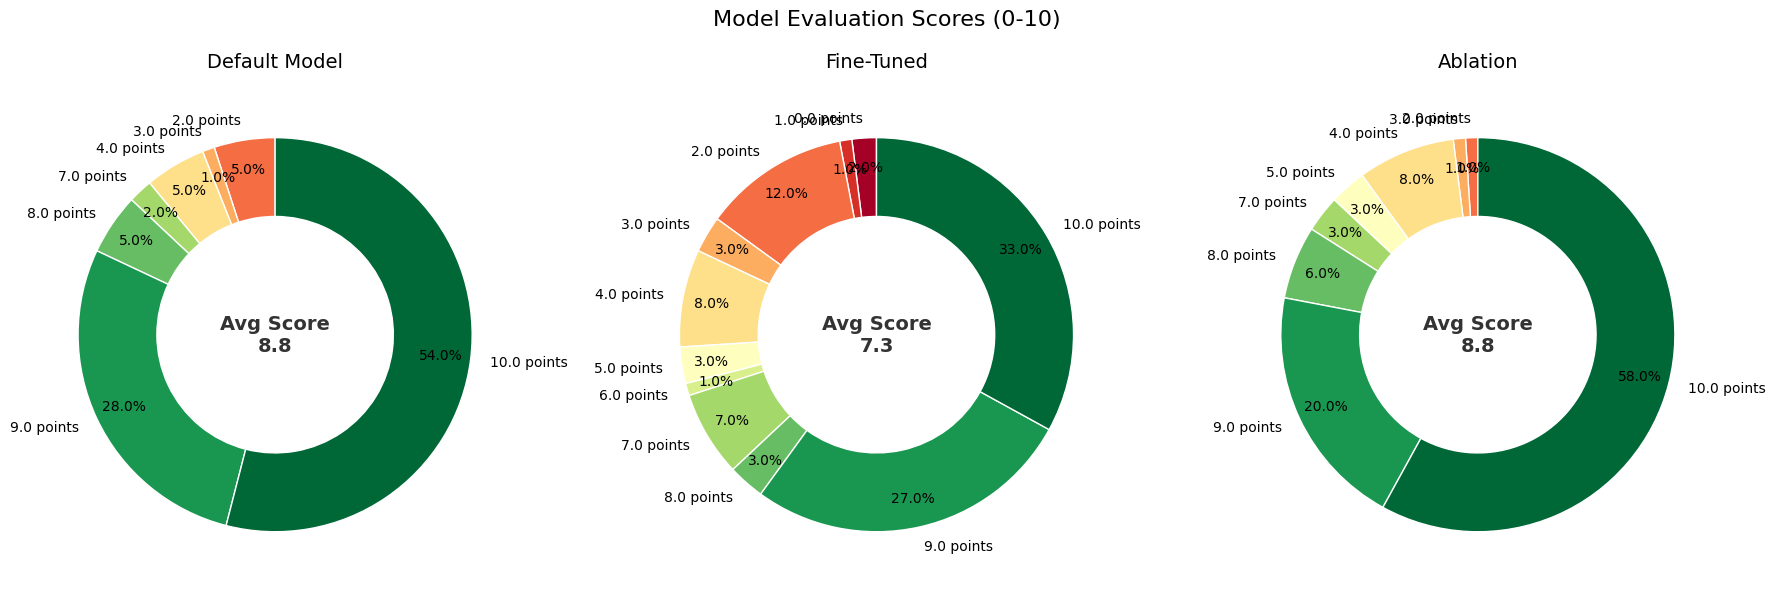

In [22]:
data_pack = [
    ("Default Model", scores_default, avg_dft),
    ("Fine-Tuned",    scores_ft,      avg_ft),
    ("Ablation",      scores_abl,     avg_abl),
]

cmap = plt.get_cmap('RdYlGn')

def get_color(score):
    return cmap(score / 10.0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (title, data_list, avg_val) in zip(axes, data_pack):
    counts = Counter(data_list)

    sorted_scores = sorted(counts.keys())
    sizes = [counts[s] for s in sorted_scores]

    chart_colors = [get_color(s) for s in sorted_scores]
    labels = [f"{s} points" for s in sorted_scores]

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=chart_colors,
        pctdistance=0.85,
        wedgeprops=dict(width=0.4, edgecolor='w', linewidth=1)
    )

    ax.set_title(title, fontsize=14, pad=15)

    ax.text(0, 0,
            f"Avg Score\n{avg_val:.1f}",
            ha='center', va='center',
            fontsize=14, fontweight='bold', color='#333333')

plt.suptitle("Model Evaluation Scores (0-10)", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Let's check the retry time of the three cases!

In [23]:
n_retry_default = [item[2] for item in ans_default]
avg_retry_default = (0.0+sum(n_retry_default)/len(n_retry_default))

n_retry_ft = [item[2] for item in ans_ft]
avg_retry_ft = (0.0+sum(n_retry_ft)/len(n_retry_ft))

n_retry_abl = [item[2] for item in ans_abl]
avg_retry_abl = (0.0+sum(n_retry_abl)/len(n_retry_abl))

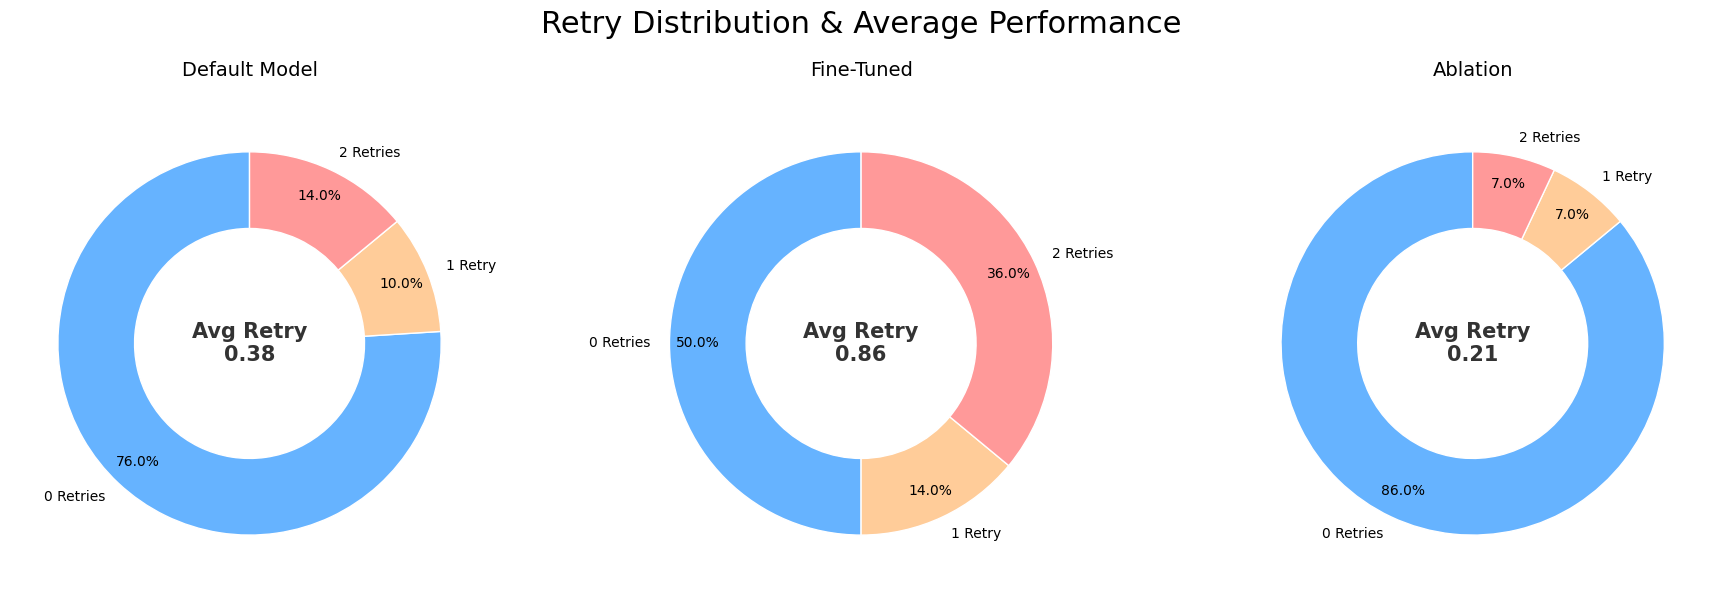

In [24]:
data_pack = [
    ("Default Model", n_retry_default, avg_retry_default),
    ("Fine-Tuned",    n_retry_ft,      avg_retry_ft),
    ("Ablation",      n_retry_abl,     avg_retry_abl),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors_map = {
    0: '#66b3ff',
    1: '#ffcc99',
    2: '#ff9999'
}
labels_map = ["0 Retries", "1 Retry", "2 Retries"]

for ax, (title, data_list, avg_val) in zip(axes, data_pack):
    counts = Counter(data_list)
    sizes = [counts.get(k, 0) for k in [0, 1, 2]]

    chart_colors = [colors_map[k] for k in [0, 1, 2]]

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels_map,
        autopct='%1.1f%%',
        startangle=90,
        colors=chart_colors,
        pctdistance=0.85,
        wedgeprops=dict(width=0.4, edgecolor='w')
    )

    ax.set_title(title, fontsize=14, pad=20)

    ax.text(0, 0,
            f"Avg Retry\n{avg_val:.2f}",
            ha='center', va='center',
            fontsize=15, fontweight='bold', color='#333333')

plt.suptitle("Retry Distribution & Average Performance", fontsize=22, y= 0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### To be more clear, let's compare the averages directly!

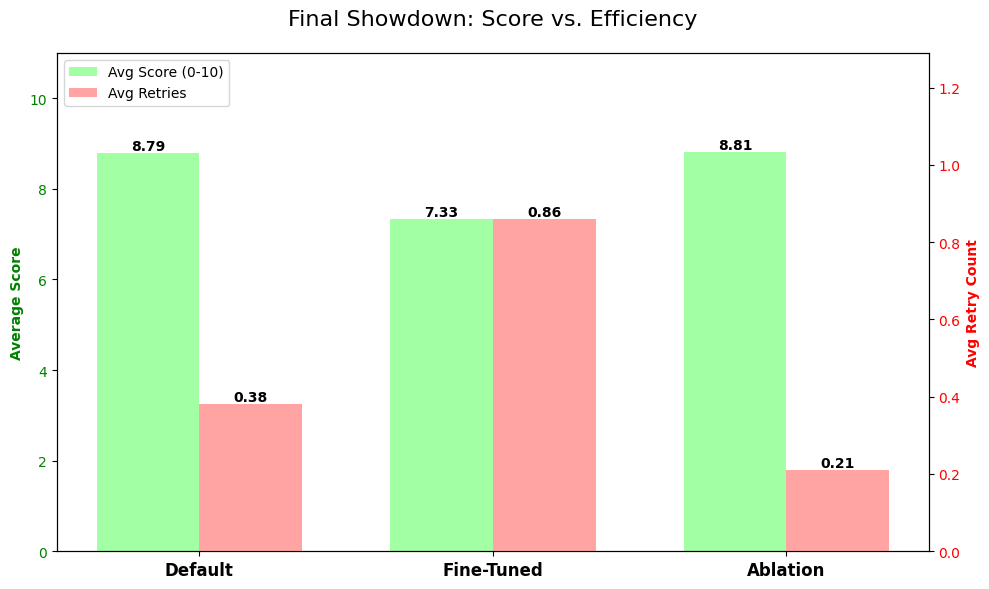

In [25]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Default', 'Fine-Tuned', 'Ablation']
avg_scores = [avg_dft, avg_ft, avg_abl]
avg_retries = [avg_retry_default, avg_retry_ft, avg_retry_abl]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

bars1 = ax1.bar(x - width/2, avg_scores, width, label='Avg Score (0-10)', color='#99ff99', alpha=0.9)
ax1.set_ylabel('Average Score', color='green', fontweight='bold')
ax1.set_ylim(0, 11)
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, avg_retries, width, label='Avg Retries', color='#ff9999', alpha=0.9)
ax2.set_ylabel('Avg Retry Count', color='red', fontweight='bold')
ax2.set_ylim(0, max(avg_retries) * 1.5)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=12, fontweight='bold')
ax1.set_title('Final Showdown: Score vs. Efficiency', fontsize=16, pad=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold')

add_labels(bars1, ax1)
add_labels(bars2, ax2)

plt.tight_layout()
plt.show()

## Observations
### Default vs. Ablation
- From the two plots shown above, it can be seen that the default setting has the similar score to that of the ablation setting. In multiple experiments, most of the time, the former scored higher than the latter, and rarely, the latter scored higher than the former.
- However, from multiple experiments, it is always observed that the default setting has a little higher number of retries than does the ablation settings.
- As the default setting uses `GPT-5.1` model as the inspector, and the ablation setting uses a much less powerful `GPT-4o-mini` model, the former inspector is able to produce a much more rigorous judge for the commands composed by the composer and find out the tiny mistakes that may be ignored by `GPT-4o-mini`, so the default setting has a little higher retry-times.

### Default vs. Fine-tuned
- Fine-tuned system works much worse than does the default settings in both metrics: it has obviously lower score and higher number of retry.
- This degradation is not entirely surprising. We only fine-tuned on a relatively small dataset of 1k examples and for a single epoch, which provides limited coverage of the full NL2Bash distribution and makes the model prone to overfitting to spurious patterns in the training set rather than learning robust general behaviors.
- In addition, the base model used for fine-tuning is `gpt-4o-mini`, which is a fast yet weak model. Even with fine-tuning, a smaller-capacity model may struggle to internalize subtle syntactic and semantic constraints of shell commands from such a limited corpus, and can easily learn brittle heuristics that do not generalize to the held-out evaluation set.


In [26]:
end_timestamp = datetime.now()
duration = end_timestamp - start_timestamp

print(f"End time: {end_timestamp.strftime('%H:%M:%S')}")
print(f"Time passed: {duration}")

End time: 00:04:17
Time passed: 0:45:31.728124
